In [1]:
#Code mostly taken from here:
#https://medium.com/analytics-vidhya/implementing-pca-in-python-with-sklearn-4f757fb4429e

import numpy as np
#Pandas is the standard pythn package for working with spreadsheets:
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Data processing, modeling, and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix

# Randomization
import random

In [2]:
# Load data:insert the relative path here, to wherever you stored the file EpilepticData.csv
df = pd.read_csv('EpilepticData.csv')

# .csv files are a common file type for storing spreadsheets.
#The above line creates a 'dataframe' object - that is what spreadsheets become in Python

# check some basic properties of your data
print("\nData Type: ", type(df))
#This shows how many samples we have and how many features each sample has (i.e. what is n in R^n)
print("Shape of the data: ",df.shape)

#Show the beginning of the table
display(df.head())
#Note that unlike in the lecture, each sample is given by a row vector and the colmuns are the features
#That is the way you usually find it in spreadsheets, if you think about it.



Data Type:  <class 'pandas.core.frame.DataFrame'>
Shape of the data:  (11500, 180)


,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


The numbers in the X1, X2, X3, etc. columns are EEG data from which one hopes to infer an upcoming
epileptic seizure. The last column labeled 'y' codifies the state of the patient. The first column just contains identifiers for the patients/measurements.

In [3]:
#One can access entries of a dataframe like an array, using row and column numbers, or by using labels:
print(df.iloc[2]['y'])
print(df.iloc[3]['X7'])
print(df.iloc[3][7])

5
-102
-102


In [4]:
# df.mean() is a list with the mean value of each column:
print(df.mean())

X1     -11.581391
X2     -10.911565
X3     -10.187130
X4      -9.143043
X5      -8.009739
          ...    
X175   -13.045043
X176   -12.705130
X177   -12.426000
X178   -12.195652
y        3.000000
Length: 179, dtype: float64


In [5]:
##a dataframe instance has fields whose name is the column label:
print(df.X4)

0        223
1        331
2        -37
3        -92
4       -102
        ... 
11495    -26
11496     77
11497    -16
11498    -12
11499     72
Name: X4, Length: 11500, dtype: int64


In [6]:
#'Scrubbing data'

# The first column just contains identifiers for the patients/measurements
# since this is not data that we want to analyse, we drop the first column 
df = df.drop('Unnamed: 0', axis=1)

# The last column labeled 'y' codifies the state of the patient. 
#'1' means that there was an epileptic seizure, the other numbers mean other things
# Re-cast the target variable (y) as either having a seizure (1) and all else (0)
for i in range(len(df)):
    if df.iloc[i]['y'] != 1:
        df.at[i, 'y'] = 0

In [7]:
#check if entries are missing
#pandas.DataFrame.isna() returns another dataframe of booleans 
# this dataframe contains 'True' at places where the entry of the original dataframe was missing
# details on isna() here:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isna.html

#sum() sums over a list - here the rows of the table; 
#for booleans 'True' is counted as 1, 'False' as 0
#details on sum() here:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html

#the following should give the total number of missing entries: 
df.isna().sum().sum()

0

In [8]:
#if there are missing values, one has to decide what to do with them, e.g. drop that row or column
# the following inserts at missing places the mean value of that column
df = df.fillna(df.mean())
# if the number before was zero, then nothing should happen here.

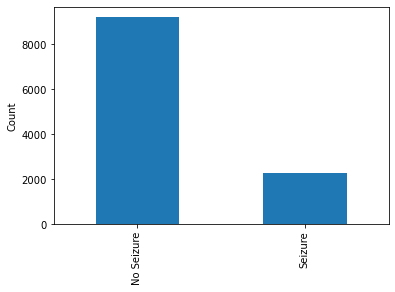

In [9]:
#we select the y-column and have a look at how many seizures actually happened - just for curiosity
y = df.y
y.value_counts().plot(kind='bar')
plt.xticks([0,1], ['No Seizure', 'Seizure'])
plt.ylabel('Count');

In [10]:
#################################################
######                 PCA                  #####
#################################################
#We create a new dataframe without the 'y'-column because the 'y'-column does not 
# contain numerical values that we want to do PCA on.
X = df.drop('y', axis=1)

In [11]:
#################################################
######               Important              #####
#################################################
#
# With PCA we try to find the directions of biggest variance.
# If we do it right away, this is highly dependent on the units. 
# E.g. if we have time measurements, we could measure them in seconds, getting large numbers, 
# or in hours, getting small numbers. The variation around the mean would be big in the first case
# and small in the second case.
#
# To escape that dependency, we normalize the data, using sklearn.preprocessing.StandardScaler
# details here:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# create a Scaler object on which we can call the normalizing method
scaler = StandardScaler()
# then do it and replace our X by the normalized X
X = scaler.fit_transform(X)

In [12]:
# Now we can do PCA
# Of course this has been implemented somwhere. Namely here: sklearn.decomposition.PCA
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

# The following is the standard pattern of how the package sklearn works with data:
# First create an instance of an object where the right methods are implemented
pca = PCA(n_components=178)
#The parameter n_components=178 sets the dimension to which we want to project down our feature space. 
#Here we choose the number of features equal to the total number of columns in our data set.
#This way we just are given a basis for which the features are uncorrelated, but we don't loose any dimensions.
#If you choose a smaller number, your data gets projected down to the correponding subspace.

# Again a standard pattern of sklearn: you call a method of your new object, typically called fit(),
#     giving it the data that you want to work on:
pca.fit(X)

#the following creates an array containing the projections to the first n_components (here: 178, i.e. all)
# of the row vectors i the original dataframe
X_pca = pca.transform(X)
print(type(X_pca))
print(X_pca)

<class 'numpy.ndarray'>
[[-1.37474913e-01 -1.14641937e+00  8.36892734e-01 ...  3.11259333e-02
  -3.30288374e-02  2.33216823e-02]
 [-1.70379440e+00 -3.64319465e+00  6.15382229e+00 ...  6.23005922e-02
  -5.86306632e-03 -4.49057067e-03]
 [ 4.95650002e-01 -2.61660144e-01  9.31210184e-01 ... -1.26348257e-02
  -1.91443144e-03  3.83408791e-03]
 ...
 [-2.89068405e-01 -2.01161410e-01 -3.56597039e-01 ... -1.02337086e-02
   5.05472804e-03 -1.09128673e-02]
 [-1.75793096e-01 -1.15579805e+00  5.41456238e-01 ...  2.56130392e-02
   1.05294373e-02  1.89406435e-02]
 [-4.34794119e-02  3.12822080e-01  2.01408663e-01 ... -3.97709687e-03
   2.19745214e-03  1.55542907e-02]]


In [13]:
#If you want to know the new basis, after the transformation, here is how:
basis = pca.components_
print(basis)

[[ 0.0013952   0.00837304  0.01641921 ... -0.06724678 -0.06073839
  -0.05214166]
 [-0.03035457 -0.03686639 -0.0452056  ... -0.09298611 -0.08273729
  -0.06734102]
 [ 0.01415224  0.00800553  0.00103555 ... -0.04066602 -0.04688284
  -0.04642837]
 ...
 [ 0.00081126  0.00156049 -0.00288184 ...  0.03021855 -0.02901933
   0.00995934]
 [-0.01166241  0.03706982 -0.02761195 ... -0.01237273 -0.03489458
   0.02032617]
 [ 0.00203486 -0.00928443  0.01881239 ...  0.01157808 -0.03595711
   0.01716547]]


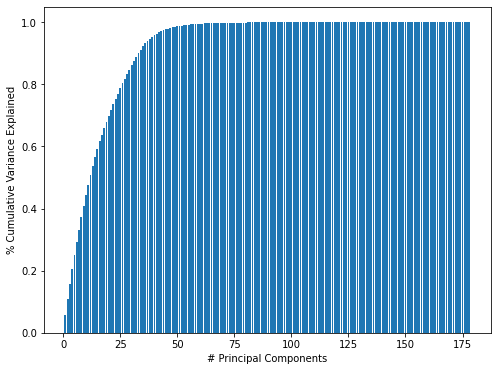

In [14]:
# a PCA object comes with an array called explained_variance_ratio_ which
# keeps track of the variance that each component displays 
# (they say that each component 'explains' a part of the variance)

# The components are ordered by size of this explained_variance_ratio

# we now look at how much of the variance is captured by the first n components for all n 
cumulative_explained_variance = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cumulative_explained_variance.append(var_exp)

# Plot cumulative explained variance for all PCs
# never mind how this here works
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,179), cumulative_explained_variance)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');

In [ ]:
# Ok, the main task here was for you to read this and see a somewhat realistic example.
# Just so you have to do something, here is an exercise (has not much to do with PCA, just write some Python):

# Assume that there is a PCA object called 'pca' (so that you can run the function after the above code).

# a) (4 points) Write a function that receives one parameter, a float between zero and one, 
# and returns the number of components that you need to explain at least that percentage of the total variance.



# b) (1 point) Apply the function to the above PCA object and compute how many components 
# you need to get at least 30 / 50 / 80 / 95 % of the total variance
# You can check with the chart above whether your results are reasonable.



# c) (5 points) Perform the same analysis, i.e. compute how many components 
# you need to get at least  30 / 50 / 80 / 95 % of the total variance, for the iris data set. 
# Just reuse the above code: Copy _only the necessary parts_ here and change them in the few appropriate places.



